C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

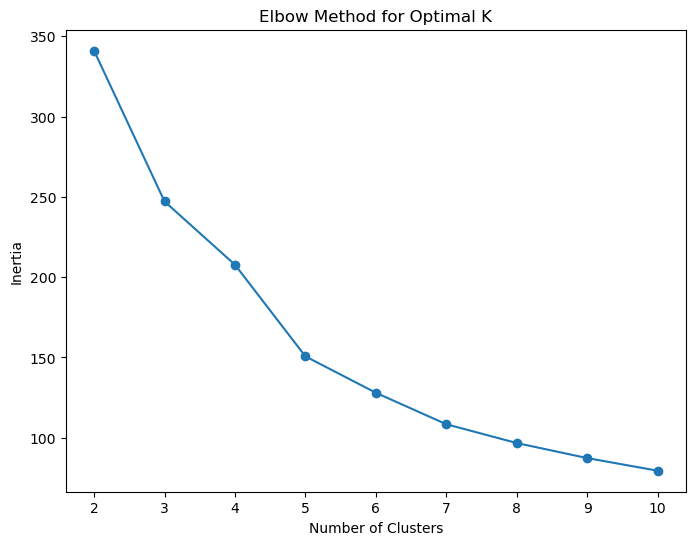

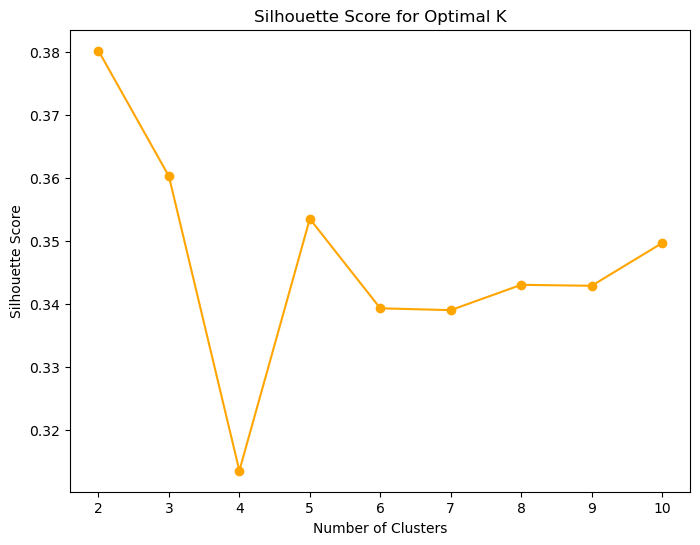

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Optimal number of clusters: 3
Davies-Bouldin Index: 0.9578205962311453
Silhouette Score: 0.36027262783851616


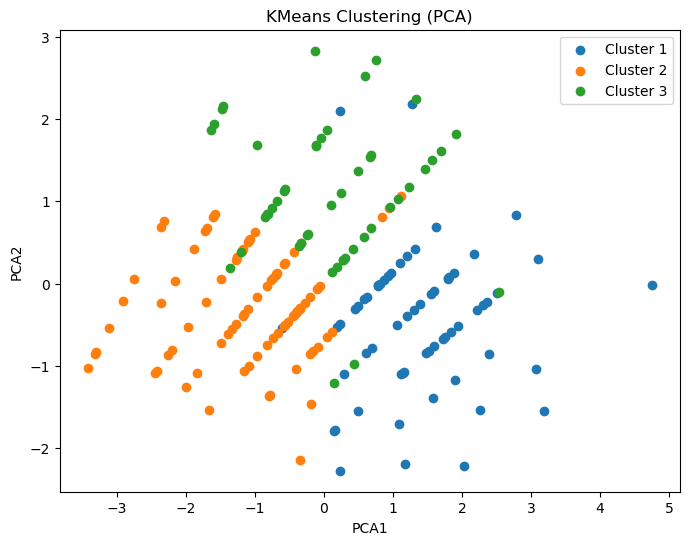

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler

# Load your data
df1 = pd.read_csv('customers.csv')
df2 = pd.read_csv('products.csv')
df3 = pd.read_csv('transactions.csv') 
df3_features = df3.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    transaction_count=('TotalValue', 'count'),
    avg_transaction_value=('TotalValue', 'mean')
).reset_index()
customer_data = pd.merge(df1, df3_features, on='CustomerID', how='left')
customer_data = customer_data.dropna(subset=['total_spent', 'transaction_count', 'avg_transaction_value'])
customer_data[['total_spent', 'transaction_count', 'avg_transaction_value']] = customer_data[['total_spent', 'transaction_count', 'avg_transaction_value']].fillna(customer_data[['total_spent', 'transaction_count', 'avg_transaction_value']].mean())

# Step 1: Remove non-numeric columns (e.g., customer_id)
customer_data_numeric = customer_data.select_dtypes(include=[np.number])

# Step 2: Data Preprocessing (Standardization of data)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data_numeric)

# Step 3: Determine the optimal number of clusters (using the Elbow Method)
inertia = []
silhouette_scores = []

for k in range(2, 11):  # Experimenting with clusters between 2 and 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    
    # Inertia (Within-cluster sum of squares)
    inertia.append(kmeans.inertia_)
    
    # Silhouette Score
    silhouette_avg = silhouette_score(scaled_data, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot the Elbow Method (Inertia vs. Number of Clusters)
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Plot the Silhouette Score vs. Number of Clusters
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Step 4: Select the optimal number of clusters
optimal_k = 3  # Example: After observing the Elbow plot and Silhouette score

# Step 5: Perform KMeans clustering with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_data)
customer_data['Cluster'] = kmeans.labels_

# Step 6: Calculate Clustering Metrics
db_index = davies_bouldin_score(scaled_data, kmeans.labels_)
silhouette_avg = silhouette_score(scaled_data, kmeans.labels_)

print(f"Optimal number of clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")

# Step 7: Visualize the Clusters using PCA for 2D plot
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

# Create a DataFrame with PCA components and cluster labels
pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = customer_data['Cluster']

# Plot the clusters
plt.figure(figsize=(8, 6))
for cluster in range(optimal_k):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster+1}')

plt.title('KMeans Clustering (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

# Optionally, save the results to a CSV file
customer_data.to_csv('Customer_Clusters.csv', index=False)
